<a href="https://colab.research.google.com/github/alvaroame/hackatonCaixa/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 86 kB/s 


In [ ]:
!pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 5.3 MB/s 
     |████████████████████████████████| 76 kB 4.9 MB/s 
     |████████████████████████████████| 9.8 MB 42.1 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.0
    Uninstalling tqdm-4.64.0:
      Successfully uninstalled tqdm-4.64.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
# Modelling and Forecasting
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load



# **Exploración**

## **Carga de Datos y Resumen general de las variables**

In [ ]:
trainDF = pd.read_csv('train.csv', sep=',', encoding='utf-8')
trainDF.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Target
0,1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1,1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
2,1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
3,1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1


In [ ]:
#Si los tipos de datos se cargaron correctamente
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6554 entries, 0 to 6553
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6554 non-null   object 
 1   Open       6421 non-null   float64
 2   High       6421 non-null   float64
 3   Low        6421 non-null   float64
 4   Close      6421 non-null   float64
 5   Adj Close  6421 non-null   float64
 6   Volume     6421 non-null   float64
 7   Target     6554 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 409.8+ KB


In [ ]:
#Vemos si tenemos missing values
trainDF.isna().sum()

Date           0
Open         133
High         133
Low          133
Close        133
Adj Close    133
Volume       133
Target         0
dtype: int64

In [ ]:
#Comprobamos que los valores que faltan sean de los mismos registros
trainDF[trainDF['Open'].isna()].head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Target
3,1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
64,1994-04-01,NaN,NaN,NaN,NaN,NaN,NaN,0
65,1994-04-04,NaN,NaN,NaN,NaN,NaN,NaN,0
85,1994-05-02,NaN,NaN,NaN,NaN,NaN,NaN,0
202,1994-10-12,NaN,NaN,NaN,NaN,NaN,NaN,0
216,1994-11-01,NaN,NaN,NaN,NaN,NaN,NaN,0
222,1994-11-09,NaN,NaN,NaN,NaN,NaN,NaN,0
241,1994-12-06,NaN,NaN,NaN,NaN,NaN,NaN,0
243,1994-12-08,NaN,NaN,NaN,NaN,NaN,NaN,0
255,1994-12-26,NaN,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
#Verificamos que no existan predicciones en estos valores
trainDF[trainDF['Open'].isna() & trainDF['Target']==1].head(50)

,Date,Open,High,Low,Close,Adj Close,Volume,Target


In [ ]:
#Observamos un summary de los datos
trainDF.describe()

,Open,High,Low,Close,Adj Close,Volume,Target
count,6421.000000,6421.000000,6421.000000,6421.000000,6421.000000,6.421000e+03,6554.000000
mean,8936.540448,9005.235576,8858.340567,8934.978558,8934.970624,8.218074e+07,0.516936
std,2732.102441,2749.009324,2712.511028,2731.032625,2731.030170,1.231845e+08,0.499751
min,2865.100098,2877.300049,2833.600098,2865.100098,2865.097168,0.000000e+00,0.000000
25%,7732.399902,7817.200195,7641.500000,7727.799805,7727.791992,0.000000e+00,0.000000
50%,9329.700195,9404.599609,9243.000000,9331.000000,9331.000000,1.966000e+05,1.000000
75%,10525.500000,10590.299805,10441.200195,10523.400391,10523.400391,1.773980e+08,1.000000
max,15999.200195,16040.400391,15868.599609,15945.700195,15945.683594,7.894902e+08,1.000000


## **La variable DATE como index principal**

In [ ]:
#Convertimos los valores de fecha a tipo datetime para trabajar mejor
trainDF['Date'] = pd.to_datetime(trainDF['Date'])
#Trabajamos con index de tiempo
trainDF = trainDF.set_index('Date')
trainDF = trainDF.sort_index()
trainDF.head()

,Open,High,Low,Close,Adj Close,Volume,Target
Date,,,,,,,
1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1


In [ ]:
#Verificamos que tengamos todos los días desde 1994/01/03 hasta 2019/05/30 
print(trainDF.index.min())
print(trainDF.index.max())
pd.date_range(start = trainDF.index.min(), end = trainDF.index.max()).difference(trainDF.index)

1994-01-03 00:00:00
2019-05-30 00:00:00


DatetimeIndex(['1994-01-08', '1994-01-09', '1994-01-15', '1994-01-16',
               '1994-01-22', '1994-01-23', '1994-01-29', '1994-01-30',
               '1994-02-05', '1994-02-06',
               ...
               '2019-04-28', '2019-05-01', '2019-05-04', '2019-05-05',
               '2019-05-11', '2019-05-12', '2019-05-18', '2019-05-19',
               '2019-05-25', '2019-05-26'],
              dtype='datetime64[ns]', length=2725, freq=None)

In [ ]:
#Solo se tienen datos que son dias laborables. Fines de semana no se opera en la bolsa
trainDF.head(8)

,Open,High,Low,Close,Adj Close,Volume,Target
Date,,,,,,,
1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1
1994-01-10,3655.199951,3678.199951,3655.199951,3660.600098,3660.596436,0.0,1
1994-01-11,3679.699951,3712.500000,3679.699951,3712.399902,3712.396240,0.0,1
1994-01-12,3712.300049,3712.300049,3675.899902,3680.100098,3680.096436,0.0,1


In [ ]:
#Al tener valores de dias laborables, verificamos que no tengamos fines de semana
trainDF['FINSEMANA'] = [1 if x > 4 else 0 for x in trainDF.index.dayofweek]
trainDF[trainDF['FINSEMANA'] == 1]

,Open,High,Low,Close,Adj Close,Volume,Target,FINSEMANA
Date,,,,,,,,


## **Graficamos las variables para observar su comportamiento durante el periodo**

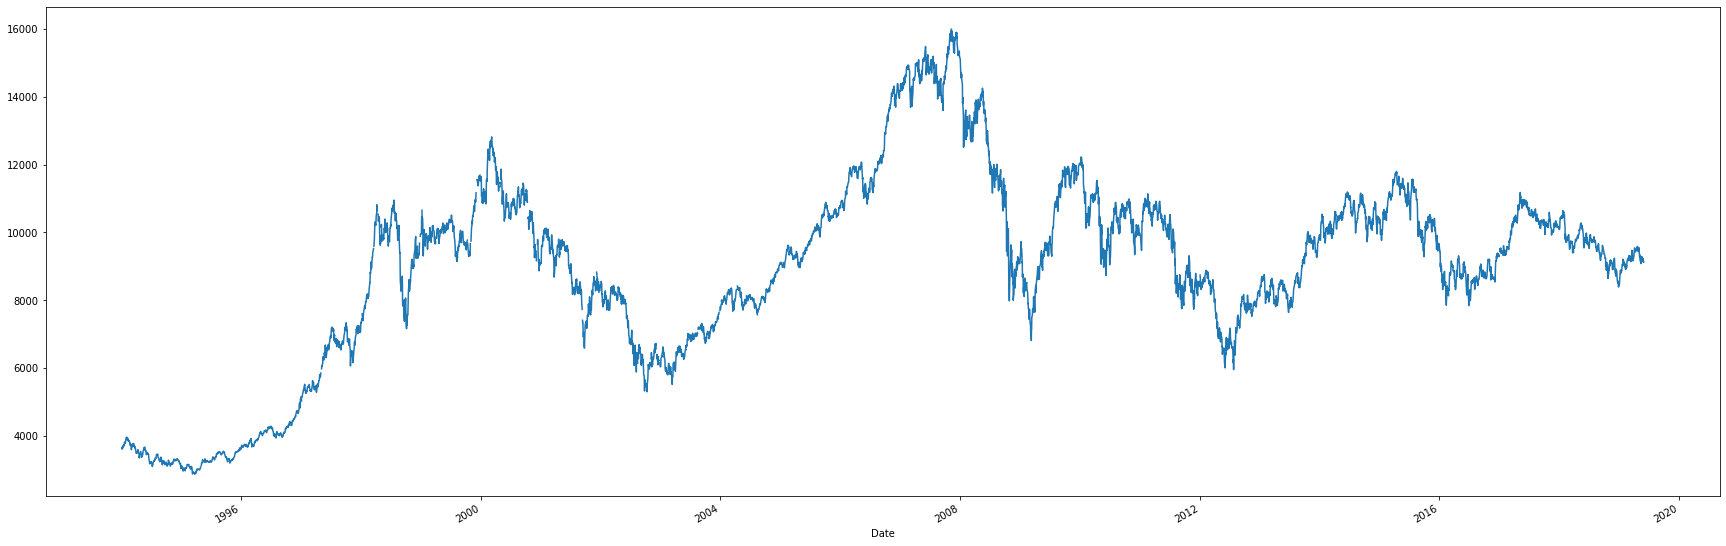

In [ ]:
#Graficamos la variable Opena durante el tiempo
trainDF['Open'].plot(figsize=(30,10))

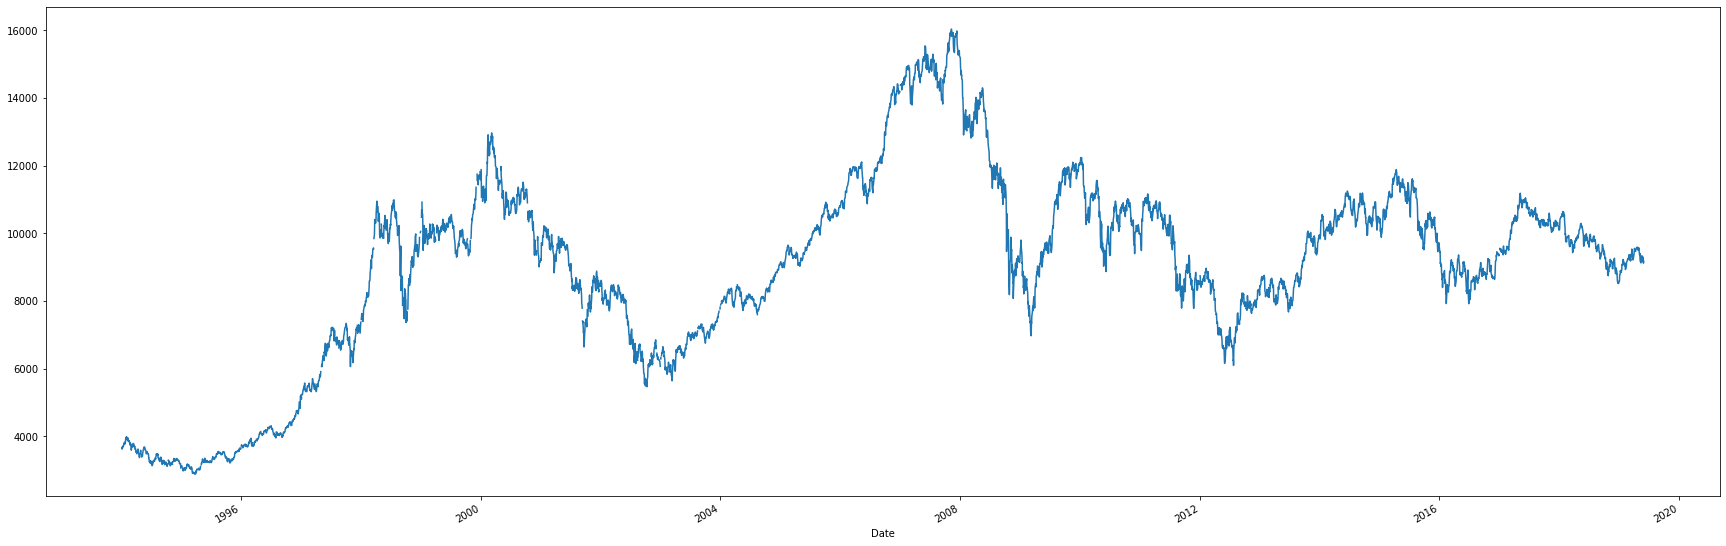

In [ ]:
#Graficamos la variable High durante el tiempo
trainDF['High'].plot(figsize=(30,10))

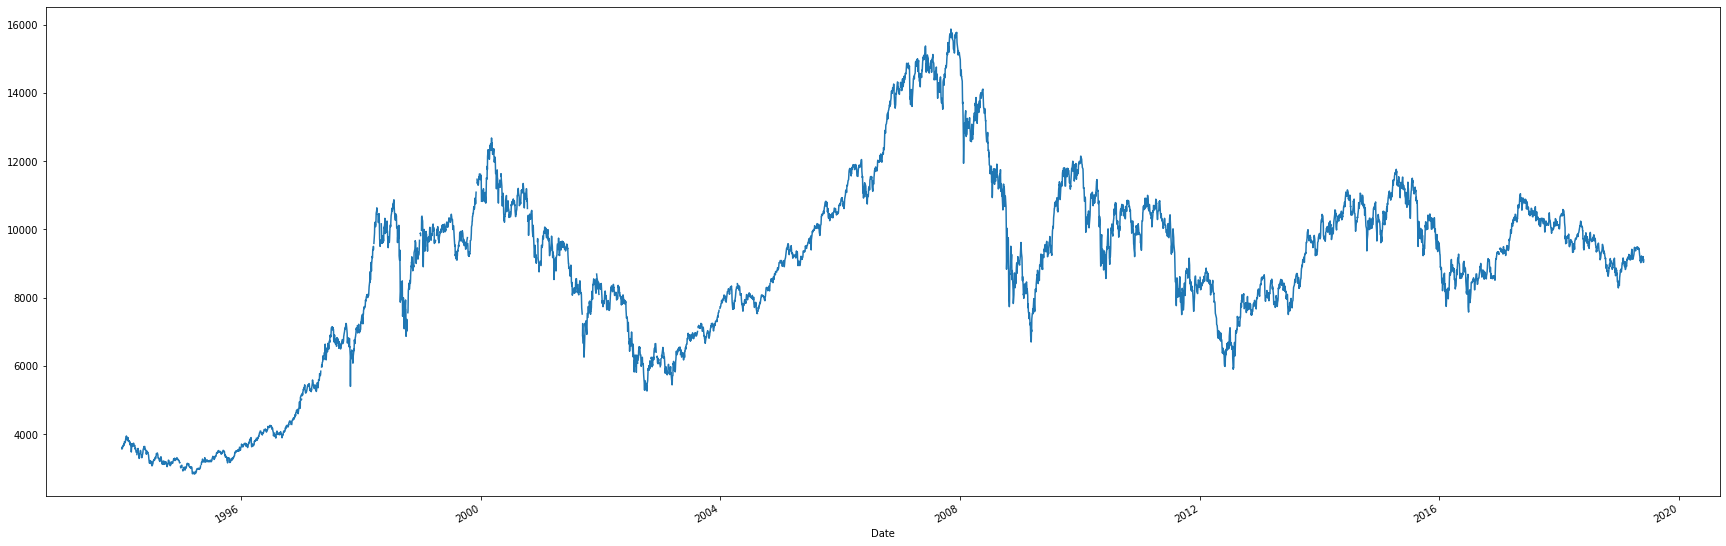

In [ ]:
#Graficamos la variable Low durante el tiempo
trainDF['Low'].plot(figsize=(30,10))

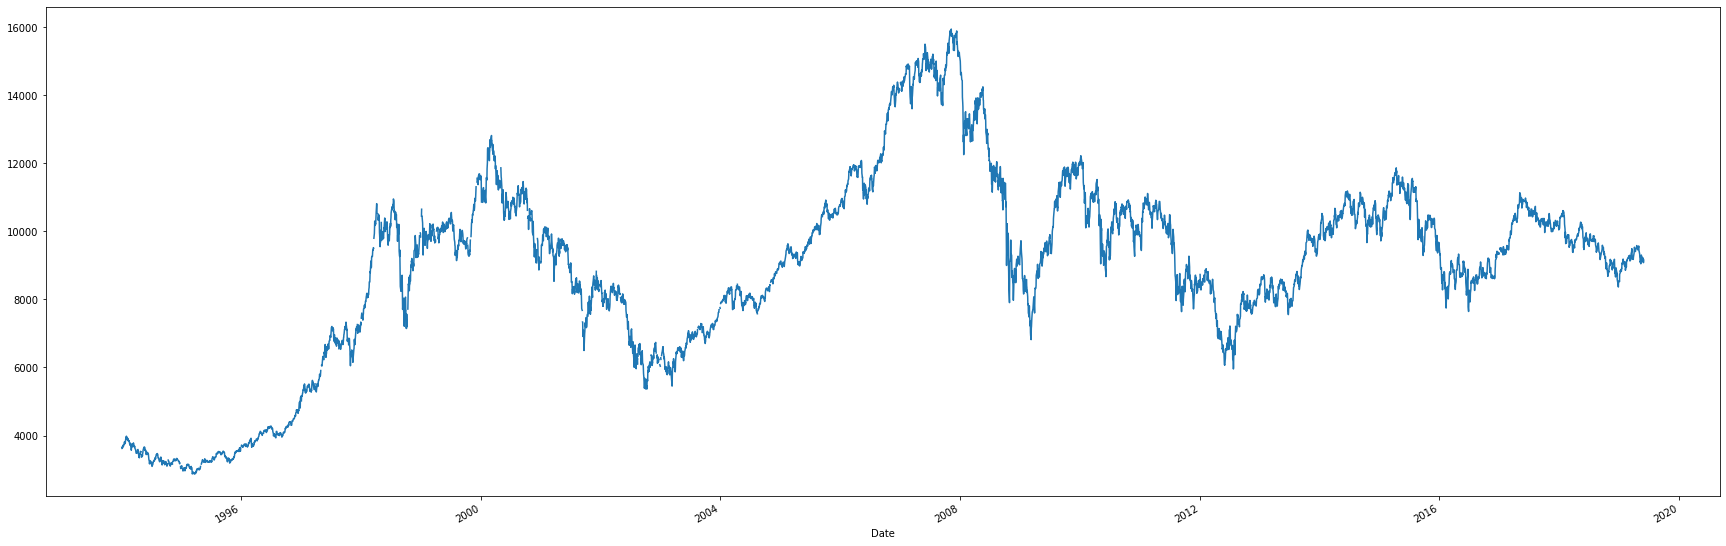

In [ ]:
#Graficamos la variable Close durante el tiempo
trainDF['Close'].plot(figsize=(30,10))

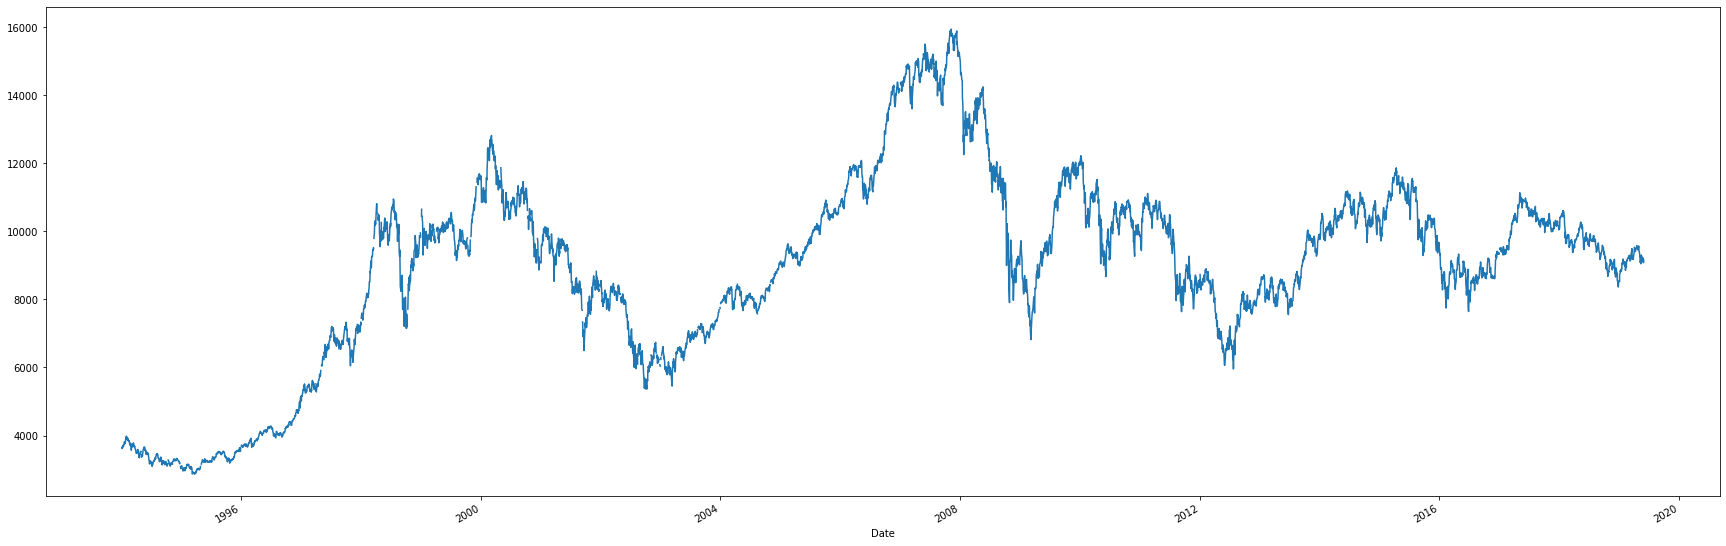

In [ ]:
#Graficamos la variable Close durante el tiempo
trainDF['Adj Close'].plot(figsize=(30,10))

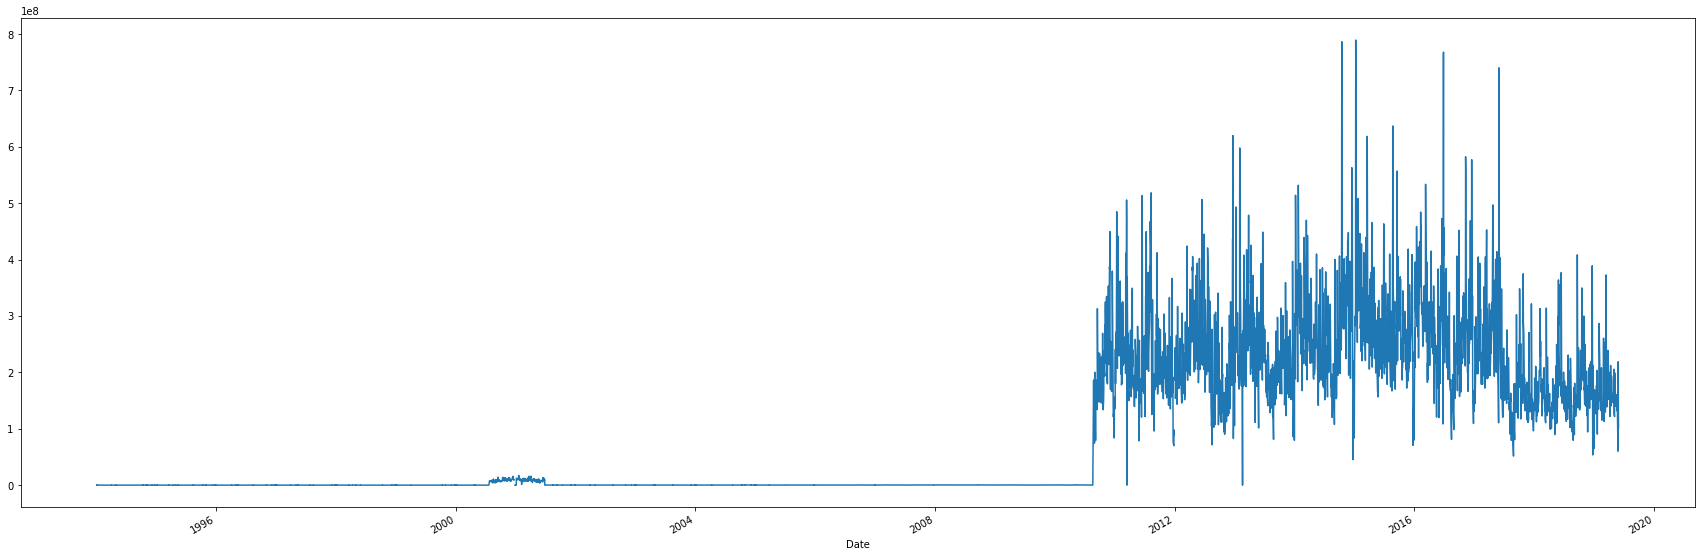

In [ ]:
#Graficamos la variable Close durante el tiempo
trainDF['Volume'].plot(figsize=(30,10))

## **Buscamos Outliers**

In [ ]:
#Realizamos la detección de outliers utilizando el rango intercuartilico
#k=3 para identificar valores extremos
def out_iqr(s, k=3):
    # Calculo del rango intercuartilico
    q25, q75 = np.percentile(s, 25), np.percentile(s, 75)
    iqr = q75 - q25
    # calculo del umbral de outliers
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    return [1 if x < lower or x > upper else 0 for x in s]

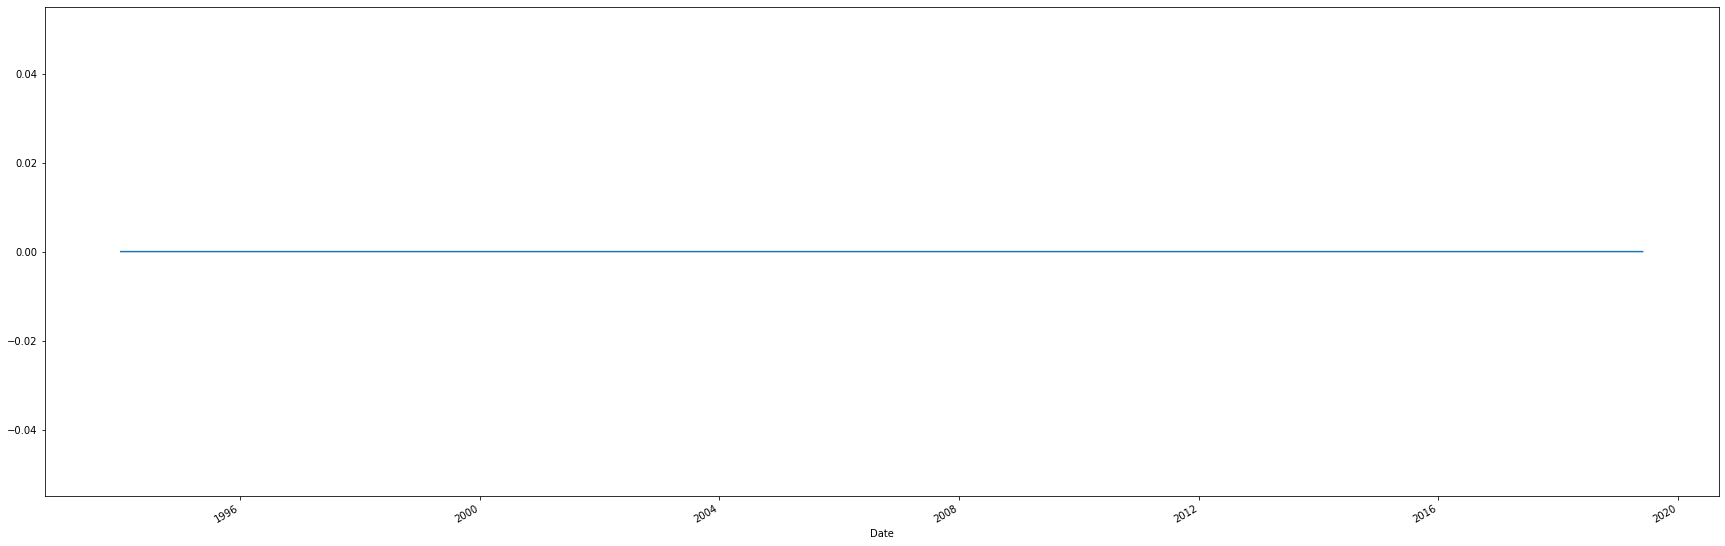

In [ ]:
#Variable open
trainDF['outliers'] = out_iqr(trainDF['Open'], k=3)
trainDF['outliers'].plot(figsize=(30,10))

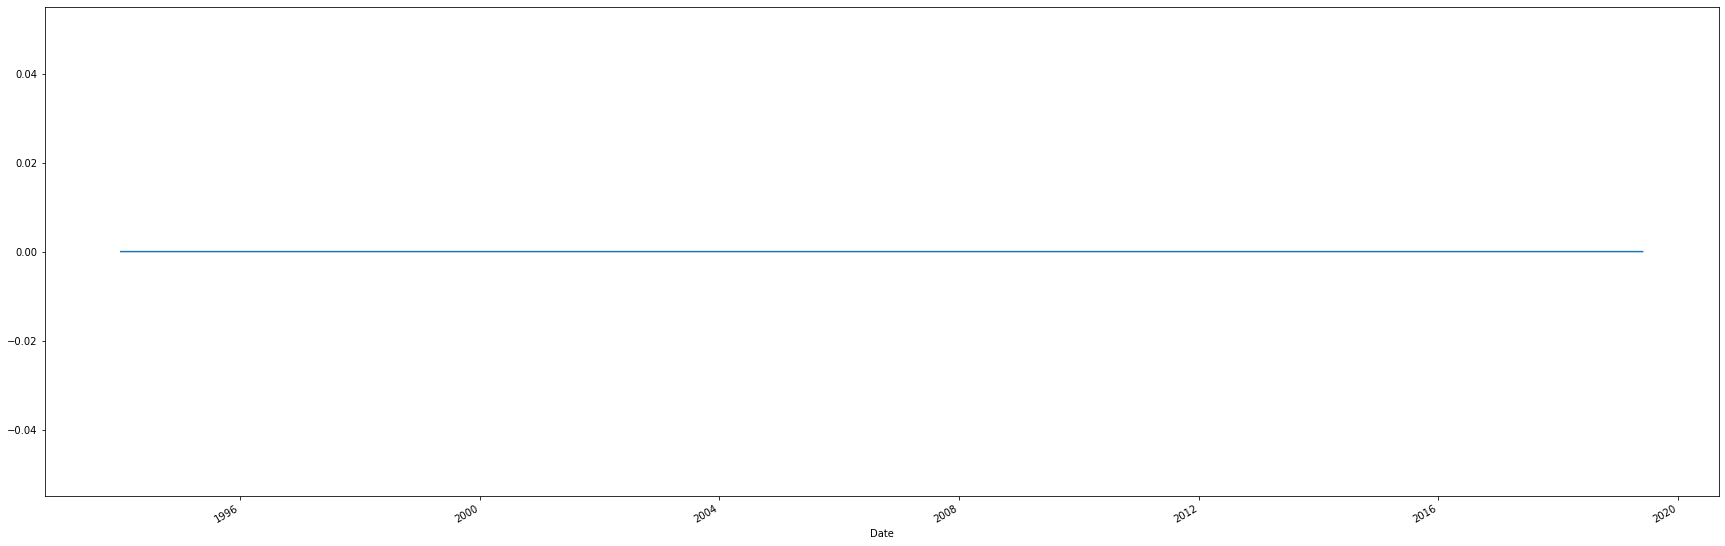

In [ ]:
#Variable high
trainDF['outliers'] = out_iqr(trainDF['High'], k=3)
trainDF['outliers'].plot(figsize=(30,10))

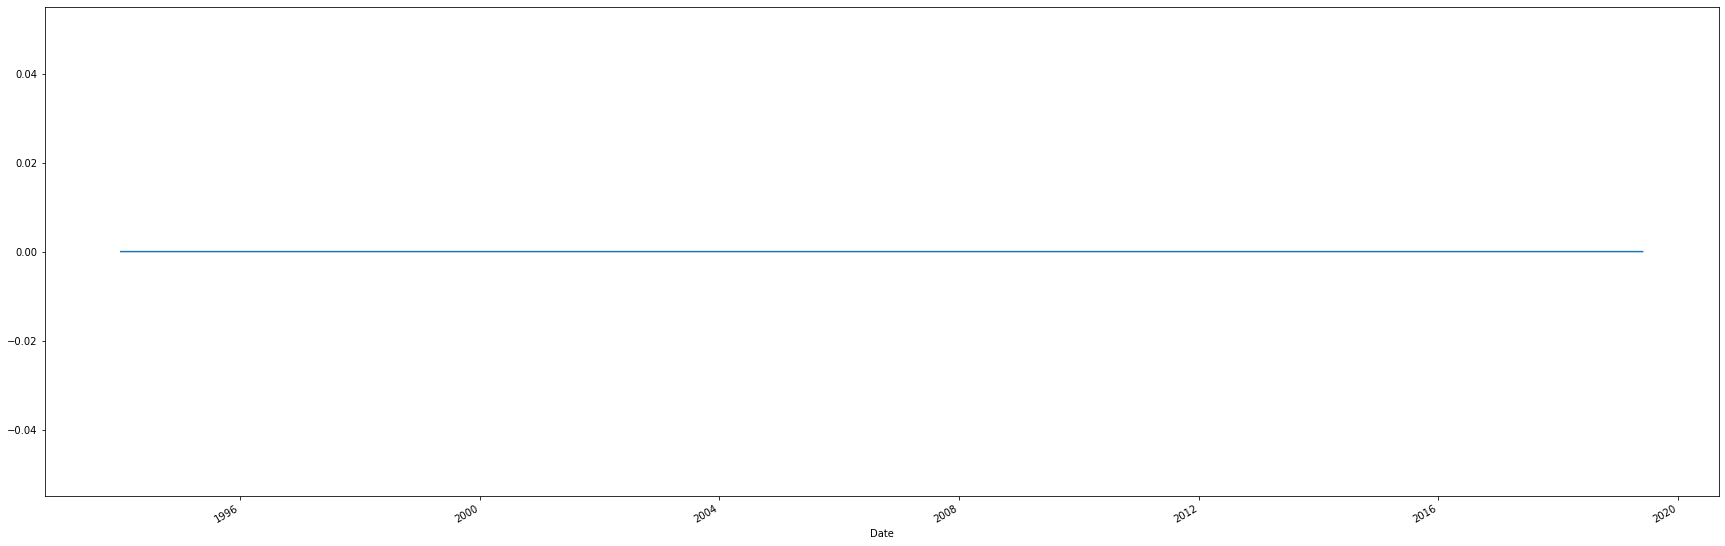

In [ ]:
#Variable Low
trainDF['outliers'] = out_iqr(trainDF['Low'], k=3)
trainDF['outliers'].plot(figsize=(30,10))

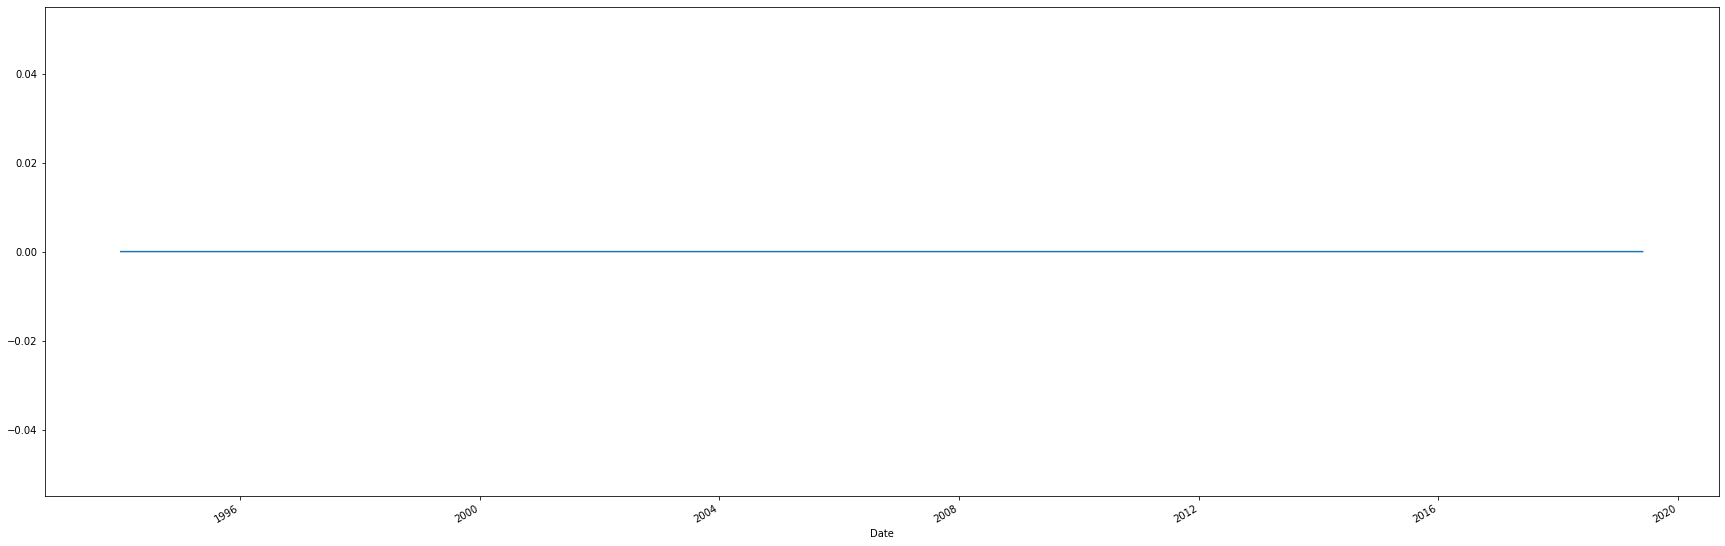

In [ ]:
#Variable Close
trainDF['outliers'] = out_iqr(trainDF['Close'], k=3)
trainDF['outliers'].plot(figsize=(30,10))

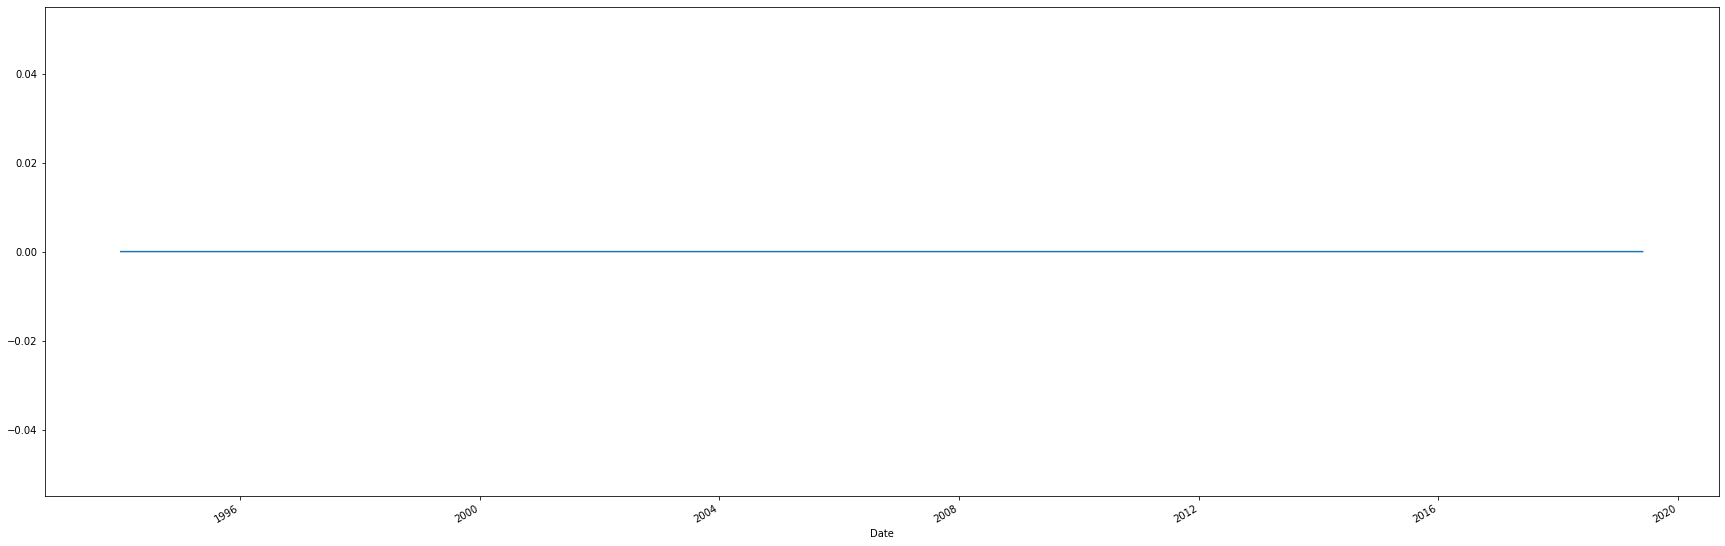

In [ ]:
#Variable Adj Close
trainDF['outliers'] = out_iqr(trainDF['Adj Close'], k=3)
trainDF['outliers'].plot(figsize=(30,10))

# **Prepocesamiento de los datos**

## **Tratamiento para Valores Nulos**

In [ ]:
#Sabemos que tenemos valores nulos
trainDF[trainDF['Open'].isna()]

,Open,High,Low,Close,Adj Close,Volume,Target,FINSEMANA,outliers
Date,,,,,,,,,
1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1994-04-01,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1994-04-04,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1994-05-02,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1994-10-12,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...
2005-12-26,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2007-01-01,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2007-12-24,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
#Marcamos los valores con valores nulos
trainDF['Nulos'] = [1 if x == x else 0 for x in trainDF['Open']]
trainDF[trainDF['Nulos'] == 0]

,Open,High,Low,Close,Adj Close,Volume,Target,FINSEMANA,outliers,Nulos
Date,,,,,,,,,,
1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1994-04-01,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1994-04-04,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1994-05-02,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1994-10-12,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2005-12-26,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2007-01-01,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2007-12-24,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0


In [ ]:
#Completamos los nulos realizando interpolacion
trainDF = trainDF.fillna(trainDF.interpolate().ffill().bfill())

In [ ]:
trainDF[trainDF['Nulos'] == 0]

,Open,High,Low,Close,Adj Close,Volume,Target,FINSEMANA,outliers,Nulos
Date,,,,,,,,,,
1994-01-06,3623.199951,3634.799926,3591.049926,3628.799926,3628.796264,0.0,0,0,0,0
1994-04-01,3487.933431,3507.266765,3458.833333,3487.200033,3487.196615,0.0,0,0,0,0
1994-04-04,3486.766765,3496.433431,3433.366618,3485.299967,3485.296549,0.0,0,0,0,0
1994-05-02,3482.950074,3493.750000,3445.599976,3476.349976,3476.346436,0.0,0,0,0,0
1994-10-12,3166.349976,3231.949951,3146.050049,3225.699951,3225.696655,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2005-12-26,10722.049805,10772.399903,10710.149902,10748.300293,10748.289551,84500.0,0,0,0,0
2007-01-01,14170.899902,14281.149902,14120.100098,14255.450195,14255.435547,143400.0,0,0,0,0
2007-12-24,15321.700195,15373.100098,15206.250000,15272.750000,15272.734375,267700.0,0,0,0,0


In [ ]:
#Vemos como se observa para un caso su interpolacion
trainDF.loc['1994-01-01': '1994-01-31']

,Open,High,Low,Close,Adj Close,Volume,Target,FINSEMANA,outliers,Nulos
Date,,,,,,,,,,
1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0,0,0,1
1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1,0,0,1
1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1,0,0,1
1994-01-06,3623.199951,3634.799926,3591.049926,3628.799926,3628.796264,0.0,0,0,0,0
1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1,0,0,1
1994-01-10,3655.199951,3678.199951,3655.199951,3660.600098,3660.596436,0.0,1,0,0,1
1994-01-11,3679.699951,3712.500000,3679.699951,3712.399902,3712.396240,0.0,1,0,0,1
1994-01-12,3712.300049,3712.300049,3675.899902,3680.100098,3680.096436,0.0,1,0,0,1
1994-01-13,3680.100098,3698.199951,3670.399902,3680.800049,3680.796387,0.0,1,0,0,1


In [ ]:
#Ya no tenemos valores nulos
trainDF.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Target       0
FINSEMANA    0
outliers     0
Nulos        0
dtype: int64

## **Nuevas variables**

In [ ]:
#Diferencia con los valores de los siguientes dias
trainDF['CloseM1'] = trainDF['Close'].diff(periods=1).ffill().bfill()
trainDF

,Open,High,Low,Close,Adj Close,Volume,Target,FINSEMANA,outliers,Nulos,CloseM1
Date,,,,,,,,,,,
1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0,0,0,1,-24.199951
1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1,0,0,1,-24.199951
1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1,0,0,1,-9.100098
1994-01-06,3623.199951,3634.799926,3591.049926,3628.799926,3628.796264,0.0,0,0,0,0,7.599975
1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1,0,0,1,7.599976
...,...,...,...,...,...,...,...,...,...,...,...
2019-05-24,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0,0,0,1,60.599609
2019-05-27,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0,0,0,1,41.800782
2019-05-28,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0,0,0,1,-24.600586


In [ ]:
trainDF['CloseM2'] = trainDF['Close'].diff(periods=2).ffill().bfill()
trainDF

,Open,High,Low,Close,Adj Close,Volume,Target,FINSEMANA,outliers,Nulos,CloseM1,CloseM2
Date,,,,,,,,,,,,
1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0,0,0,1,-24.199951,-33.300049
1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1,0,0,1,-24.199951,-33.300049
1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1,0,0,1,-9.100098,-33.300049
1994-01-06,3623.199951,3634.799926,3591.049926,3628.799926,3628.796264,0.0,0,0,0,0,7.599975,-1.500123
1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1,0,0,1,7.599976,15.199951
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-24,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0,0,0,1,60.599609,-57.600586
2019-05-27,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0,0,0,1,41.800782,102.400391
2019-05-28,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0,0,0,1,-24.600586,17.200196


In [ ]:
trainDF['CloseM3'] = trainDF['Close'].diff(periods=3).ffill().bfill()
trainDF

,Open,High,Low,Close,Adj Close,Volume,Target,FINSEMANA,outliers,Nulos,CloseM1,CloseM2,CloseM3
Date,,,,,,,,,,,,,
1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0,0,0,1,-24.199951,-33.300049,-25.700074
1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1,0,0,1,-24.199951,-33.300049,-25.700074
1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1,0,0,1,-9.100098,-33.300049,-25.700074
1994-01-06,3623.199951,3634.799926,3591.049926,3628.799926,3628.796264,0.0,0,0,0,0,7.599975,-1.500123,-25.700074
1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1,0,0,1,7.599976,15.199951,6.099853
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-24,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0,0,0,1,60.599609,-57.600586,-64.500000
2019-05-27,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0,0,0,1,41.800782,102.400391,-15.799804
2019-05-28,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0,0,0,1,-24.600586,17.200196,77.799805


##**Modelado**

### **Simple clasificador**

In [ ]:
trainDF = trainDF.drop(['FINSEMANA', 'outliers', 'Nulos'], axis=1)

In [ ]:
#Graficamos la correlación entre las variables
corr = trainDF.corr()

In [ ]:
corr

,Open,High,Low,Close,Adj Close,Volume,Target,CloseM1,CloseM2,CloseM3
Open,1.000000,0.999666,0.999542,0.999202,0.999202,0.139711,-0.004877,-0.018376,-0.001095,0.008221
High,0.999666,1.000000,0.999436,0.999579,0.999579,0.140499,-0.004989,-0.003092,0.008545,0.015102
Low,0.999542,0.999436,1.000000,0.999638,0.999638,0.137158,-0.004911,0.002057,0.015951,0.023720
Close,0.999202,0.999579,0.999638,1.000000,1.000000,0.138536,-0.004748,0.017202,0.024532,0.029429
Adj Close,0.999202,0.999579,0.999638,1.000000,1.000000,0.138537,-0.004748,0.017202,0.024532,0.029429
Volume,0.139711,0.140499,0.137158,0.138536,0.138537,1.000000,0.013816,-0.010099,-0.021506,-0.026880
Target,-0.004877,-0.004989,-0.004911,-0.004748,-0.004748,0.013816,1.000000,0.004123,-0.011357,-0.011784
CloseM1,-0.018376,-0.003092,0.002057,0.017202,0.017202,-0.010099,0.004123,1.000000,0.710871,0.564403
CloseM2,-0.001095,0.008545,0.015951,0.024532,0.024532,-0.021506,-0.011357,0.710871,1.000000,0.814192
CloseM3,0.008221,0.015102,0.023720,0.029429,0.029429,-0.026880,-0.011784,0.564403,0.814192,1.000000


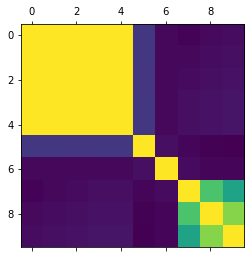

In [ ]:
plt.matshow(trainDF.corr())
plt.show()

### **Training and testing**

In [ ]:
trainDF

,Open,High,Low,Close,Adj Close,Volume,Target,CloseM1,CloseM2,CloseM3
Date,,,,,,,,,,
1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0,-24.199951,-33.300049,-25.700074
1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1,-24.199951,-33.300049,-25.700074
1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1,-9.100098,-33.300049,-25.700074
1994-01-06,3623.199951,3634.799926,3591.049926,3628.799926,3628.796264,0.0,0,7.599975,-1.500123,-25.700074
1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1,7.599976,15.199951,6.099853
...,...,...,...,...,...,...,...,...,...,...
2019-05-24,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0,60.599609,-57.600586,-64.500000
2019-05-27,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0,41.800782,102.400391,-15.799804
2019-05-28,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0,-24.600586,17.200196,77.799805


In [ ]:
X = trainDF.drop(['Target'], axis=1)
y = trainDF['Target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
y_train

Date
2012-08-30    1
2001-10-09    0
2013-04-25    1
2000-03-24    0
1995-02-01    1
             ..
2013-01-22    1
2006-07-12    0
2000-05-04    0
2003-12-31    0
2004-06-23    1
Name: Target, Length: 5243, dtype: int64

In [ ]:
X_test

,Open,High,Low,Close,Adj Close,Volume,CloseM1,CloseM2,CloseM3
Date,,,,,,,,,
1996-12-19,4815.600098,4911.700195,4807.100098,4908.899902,4908.895020,0.0,93.299804,175.600097,158.500000
1998-07-24,10614.900391,10662.400391,10479.700195,10559.200195,10559.189453,0.0,-55.700196,-1.599610,-199.200196
2001-09-11,7566.000000,7594.500000,7205.349853,7507.700195,7507.692627,131850.0,-171.000000,-219.500000,-397.000000
2012-12-04,7871.899902,7945.700195,7870.899902,7902.399902,7902.392090,135636800.0,13.199707,-32.200196,-71.300293
2016-07-22,8566.299805,8618.900391,8516.299805,8599.900391,8599.900391,299865000.0,16.300782,24.400391,114.700196
...,...,...,...,...,...,...,...,...,...
2003-02-18,6080.700195,6186.899902,6048.000000,6165.000000,6164.993652,120400.0,82.100098,192.200195,347.399902
1995-09-25,3412.199951,3412.199951,3371.300049,3382.800049,3382.796631,0.0,-40.599853,-113.500000,-124.300049
2011-02-21,11049.299805,11050.299805,10792.200195,10810.500000,10810.489258,212236000.0,-257.599609,-302.500000,-237.299805


### **XGBClassifier**

In [ ]:
#XGBClassifier
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

XGBClassifier()

In [ ]:
y_pred = xgbc.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.42      0.46       631
           1       0.53      0.62      0.57       680

    accuracy                           0.52      1311
   macro avg       0.52      0.52      0.51      1311
weighted avg       0.52      0.52      0.52      1311



In [ ]:
# - cross validataion
scores = cross_val_score(xgbc, X, y, cv=12, scoring='f1_macro')
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.47


### **SVM**

In [ ]:
#SVM
modelsvm = LinearSVC(C=1.0, penalty='l2', random_state=42, max_iter=1000, verbose=1)
# Entrenamiento del algoritmo 
modelsvm.fit(X_train, y_train)

[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(random_state=42, verbose=1)

In [ ]:
y_pred = modelsvm.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      1.00      0.65       631
           1       0.00      0.00      0.00       680

    accuracy                           0.48      1311
   macro avg       0.24      0.50      0.32      1311
weighted avg       0.23      0.48      0.31      1311



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# - cross validataion
scores = cross_val_score(modelsvm, X, y, cv=12, scoring='f1_macro')
print("Mean cross-validation score: %.2f" % scores.mean())

[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]Mean cross-validation score: 0.34


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


<Figure size 432x288 with 0 Axes>

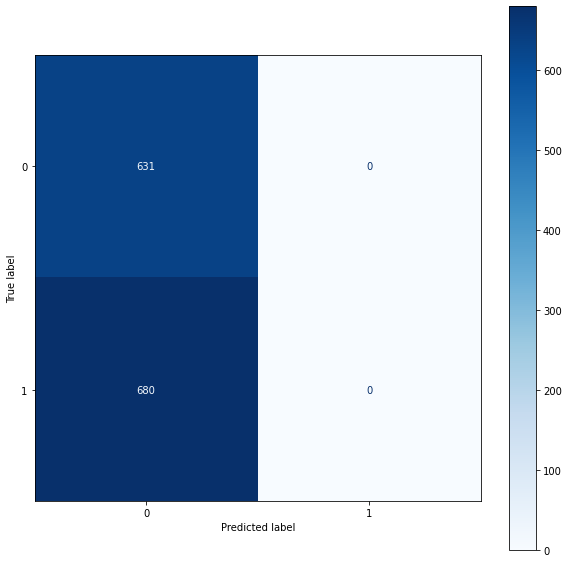

In [ ]:
#Confusion matrix test
plt.clf()
fig,ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues,  ax=ax, values_format='d')
plt.show() 

### **RandomForestClassifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

modelr = RandomForestClassifier(max_depth=2, random_state=0)
# Entrenamiento del algoritmo 
modelr.fit(X, y)

RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
y_pred = modelr.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.19      0.28       631
           1       0.54      0.88      0.67       680

    accuracy                           0.55      1311
   macro avg       0.56      0.53      0.48      1311
weighted avg       0.56      0.55      0.48      1311



In [ ]:
# - cross validataion
scores = cross_val_score(modelr, X_train, y_train, cv=12, scoring='f1_macro')
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.45


# **Regresión como Serie de Tiempo**

### **Nuevas variables**

In [ ]:
#Diferencia con los valores de los siguientes dias
trainDF['Close3'] = trainDF['Close'].shift(periods=-3).ffill().bfill()
trainDF

,Open,High,Low,Close,Adj Close,Volume,Target,Close3
Date,,,,,,,,
1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0,3628.799926
1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1,3636.399902
1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1,3660.600098
1994-01-06,3623.199951,3634.799926,3591.049926,3628.799926,3628.796264,0.0,0,3712.399902
1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1,3680.100098
...,...,...,...,...,...,...,...,...
2019-05-24,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0,9080.500000
2019-05-27,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0,9157.799805
2019-05-28,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0,9157.799805


In [ ]:
trainDF['ANTERIOR'] = trainDF['Close'].shift().ffill().bfill()
trainDF['DIF1'] = trainDF['Close'].diff().ffill().bfill()
trainDF['DIF3'] = trainDF['Close'].diff(periods=3).ffill().bfill()
trainDF['DIF7'] = trainDF['Close'].diff(periods=7).ffill().bfill()
trainDF['SUM3'] = trainDF['Close'].rolling(3).sum().ffill().bfill()
trainDF['SUM7'] = trainDF['Close'].rolling(7).sum().ffill().bfill()
trainDF['MEDIA3'] = trainDF['Close'].rolling(3).mean().ffill().bfill()
trainDF['MEDIA7'] = trainDF['Close'].rolling(7).mean().ffill().bfill()
trainDF['MEDIAN3'] = trainDF['Close'].rolling(3).median().ffill().bfill()
trainDF['MEDIAN7'] = trainDF['Close'].rolling(7).median().ffill().bfill()
trainDF['STD3'] = trainDF['Close'].rolling(3).std().ffill().bfill()
trainDF['STD7'] = trainDF['Close'].rolling(7).std().ffill().bfill()
trainDF['DIA'] = trainDF.index.day_name()
trainDF['DIAMES'] = trainDF.index.day
trainDF['SEMANA'] = trainDF.index.isocalendar().week
trainDF['MES'] = trainDF.index.month

In [ ]:
trainDF

,Open,High,Low,Close,Adj Close,Volume,Target,Close3,ANTERIOR,DIF1,...,MEDIA3,MEDIA7,MEDIAN3,MEDIAN7,STD3,STD7,DIA,DIAMES,SEMANA,MES
Date,,,,,,,,,,,,,,,,,,,,,
1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0,3628.799926,3654.500000,-24.199951,...,3635.333333,3649.171404,3630.300049,3636.399902,17.211153,31.287619,Monday,3,1,1
1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1,3636.399902,3654.500000,-24.199951,...,3635.333333,3649.171404,3630.300049,3636.399902,17.211153,31.287619,Tuesday,4,1,1
1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1,3660.600098,3630.300049,-9.100098,...,3635.333333,3649.171404,3630.300049,3636.399902,17.211153,31.287619,Wednesday,5,1,1
1994-01-06,3623.199951,3634.799926,3591.049926,3628.799926,3628.796264,0.0,0,3712.399902,3621.199951,7.599975,...,3626.766642,3649.171404,3628.799926,3636.399902,4.878896,31.287619,Thursday,6,1,1
1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1,3680.100098,3628.799926,7.599976,...,3628.799926,3649.171404,3628.799926,3636.399902,7.599975,31.287619,Friday,7,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-24,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0,9080.500000,9114.000000,60.599609,...,9173.599935,9220.571289,9174.599609,9232.200195,59.106438,64.470992,Friday,24,21,5
2019-05-27,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0,9157.799805,9174.599609,41.800782,...,9168.333333,9208.014230,9174.599609,9216.400391,51.486986,52.981485,Monday,27,22,5
2019-05-28,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0,9157.799805,9216.400391,-24.600586,...,9194.266602,9195.399972,9191.799805,9199.700195,21.009287,42.416577,Tuesday,28,22,5


## **Split en Training, Testing y Valitation**

In [ ]:
#Funcion para generar el dataset con toda las variables
def transform_variables(df, target, variables =[], categorical=[]):
  new_df = df.sort_values(['Date'])
  #Eliminamos las variables no necesarias y mantenemos las solicitadas
  variables_comp = []
  variables_comp.extend(variables)
  variables_comp.extend(categorical)
  variables_comp.extend([target])
  new_df = new_df.drop(columns=[col for col in new_df if col not in variables_comp])
  # Las variables categoricas les cambiamos su tipo
  for categoria in categorical:
    new_df[categoria] = new_df[categoria].astype('category')
  # One hot encoding
  new_df = pd.get_dummies(new_df, columns=categorical)
  return new_df

In [ ]:
#Funcion para generar los conjuntos de entrenamiento, prueba y validación
def train_test_split_by_date(df, fin_train, fin_validation, target):
  
  dfP = df.sort_values(['Date']).reset_index()
  #Dividimos el dataset
  X_train = dfP.loc[(dfP['Date'] < fin_train)].set_index('Date')
  X_test   = dfP.loc[(dfP['Date'] < fin_validation) & (dfP['Date'] >= fin_train) ].set_index('Date')
  X_val   = dfP.loc[(dfP['Date'] >= fin_validation)].set_index('Date')
  
  #Extraemos la target variable
  y_train = X_train.pop(target)
  y_val = X_val.pop(target)
  y_test = X_test.pop(target)

  return X_train, y_train, X_test, y_test, X_val, y_val

In [ ]:
trainDF

,Open,High,Low,Close,Adj Close,Volume,Target,Close3,ANTERIOR,DIF1,...,MEDIA3,MEDIA7,MEDIAN3,MEDIAN7,STD3,STD7,DIA,DIAMES,SEMANA,MES
Date,,,,,,,,,,,,,,,,,,,,,
1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0,3628.799926,3654.500000,-24.199951,...,3635.333333,3649.171404,3630.300049,3636.399902,17.211153,31.287619,Monday,3,1,1
1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1,3636.399902,3654.500000,-24.199951,...,3635.333333,3649.171404,3630.300049,3636.399902,17.211153,31.287619,Tuesday,4,1,1
1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1,3660.600098,3630.300049,-9.100098,...,3635.333333,3649.171404,3630.300049,3636.399902,17.211153,31.287619,Wednesday,5,1,1
1994-01-06,3623.199951,3634.799926,3591.049926,3628.799926,3628.796264,0.0,0,3712.399902,3621.199951,7.599975,...,3626.766642,3649.171404,3628.799926,3636.399902,4.878896,31.287619,Thursday,6,1,1
1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1,3680.100098,3628.799926,7.599976,...,3628.799926,3649.171404,3628.799926,3636.399902,7.599975,31.287619,Friday,7,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-24,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0,9080.500000,9114.000000,60.599609,...,9173.599935,9220.571289,9174.599609,9232.200195,59.106438,64.470992,Friday,24,21,5
2019-05-27,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0,9157.799805,9174.599609,41.800782,...,9168.333333,9208.014230,9174.599609,9216.400391,51.486986,52.981485,Monday,27,22,5
2019-05-28,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0,9157.799805,9216.400391,-24.600586,...,9194.266602,9195.399972,9191.799805,9199.700195,21.009287,42.416577,Tuesday,28,22,5


In [ ]:
# Transformamos el df agregando las variables numericas y variables categoricas
# ==============================================================================
target = 'Close3'
categorical = ['DIA', 'MES']
variables = ['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Close', 'Target', 'DIAMES', 'SEMANA', 'ANTERIOR', 'DIF1', 'DIF3', 'DIF7', 'SUM3', 'SUM7', 'MEDIA3', 'MEDIA7', 'MEDIAN3', 'MEDIAN7', 'STD3', 'STD7']

newDF = transform_variables(trainDF, target, variables, categorical)

In [ ]:
newDF

,Open,High,Low,Close,Adj Close,Volume,Target,Close3,ANTERIOR,DIF1,...,MES_3,MES_4,MES_5,MES_6,MES_7,MES_8,MES_9,MES_10,MES_11,MES_12
Date,,,,,,,,,,,,,,,,,,,,,
1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0,3628.799926,3654.500000,-24.199951,...,0,0,0,0,0,0,0,0,0,0
1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1,3636.399902,3654.500000,-24.199951,...,0,0,0,0,0,0,0,0,0,0
1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1,3660.600098,3630.300049,-9.100098,...,0,0,0,0,0,0,0,0,0,0
1994-01-06,3623.199951,3634.799926,3591.049926,3628.799926,3628.796264,0.0,0,3712.399902,3621.199951,7.599975,...,0,0,0,0,0,0,0,0,0,0
1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1,3680.100098,3628.799926,7.599976,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-24,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0,9080.500000,9114.000000,60.599609,...,0,0,1,0,0,0,0,0,0,0
2019-05-27,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0,9157.799805,9174.599609,41.800782,...,0,0,1,0,0,0,0,0,0,0
2019-05-28,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0,9157.799805,9216.400391,-24.600586,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
# Dividimos los datos en train-val-test
# ==============================================================================
fin_train = datetime.datetime.strptime("2018-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
fin_validation = datetime.datetime.strptime("2018-12-31 23:59:59", "%Y-%m-%d %H:%M:%S")

X_train, y_train, X_test, y_test, X_val, y_val = train_test_split_by_date(newDF, fin_train, fin_validation, target)

In [ ]:
print(trainDF.index.min())
print(trainDF.index.max())

1994-01-03 00:00:00
2019-05-30 00:00:00


In [ ]:
print(X_train.index.min())
print(y_train.index.max())

1994-01-03 00:00:00
2017-12-29 00:00:00


In [ ]:
print(X_test.index.min())
print(y_test.index.max())

2018-01-02 00:00:00
2018-12-31 00:00:00


In [ ]:
print(X_val.index.min())
print(y_val.index.max())

2019-01-02 00:00:00
2019-05-30 00:00:00


In [ ]:
X_train

,Open,High,Low,Close,Adj Close,Volume,Target,ANTERIOR,DIF1,DIF3,...,MES_3,MES_4,MES_5,MES_6,MES_7,MES_8,MES_9,MES_10,MES_11,MES_12
Date,,,,,,,,,,,,,,,,,,,,,
1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0,3654.500000,-24.199951,-25.700074,...,0,0,0,0,0,0,0,0,0,0
1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1,3654.500000,-24.199951,-25.700074,...,0,0,0,0,0,0,0,0,0,0
1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1,3630.300049,-9.100098,-25.700074,...,0,0,0,0,0,0,0,0,0,0
1994-01-06,3623.199951,3634.799926,3591.049926,3628.799926,3628.796264,0.0,0,3621.199951,7.599975,-25.700074,...,0,0,0,0,0,0,0,0,0,0
1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1,3628.799926,7.599976,6.099853,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-21,10192.599609,10322.599609,10144.400391,10304.599609,10304.599609,152663400.0,0,10207.700195,96.899414,60.500000,...,0,0,0,0,0,0,0,0,0,1
2017-12-22,10145.599609,10235.799805,10138.299805,10182.000000,10182.000000,138510600.0,0,10304.599609,-122.599609,-52.299805,...,0,0,0,0,0,0,0,0,0,1
2017-12-27,10167.200195,10213.200195,10138.799805,10165.200195,10165.200195,96218000.0,0,10182.000000,-16.799805,-42.500000,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
y_train

Date
1994-01-03     3628.799926
1994-01-04     3636.399902
1994-01-05     3660.600098
1994-01-06     3712.399902
1994-01-07     3680.100098
                  ...     
2017-12-21    10093.099609
2017-12-22    10043.900391
2017-12-27    10079.099609
2017-12-28    10116.000000
2017-12-29    10314.400391
Name: Close3, Length: 6195, dtype: float64

In [ ]:
y_test

Date
2018-01-02    10411.400391
2018-01-03    10398.400391
2018-01-04    10426.500000
2018-01-05    10428.299805
2018-01-08    10435.200195
                  ...     
2018-12-21     8493.700195
2018-12-24     8539.900391
2018-12-27     8550.000000
2018-12-28     8523.299805
2018-12-31     8737.799805
Name: Close3, Length: 255, dtype: float64

## **Modelado**

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

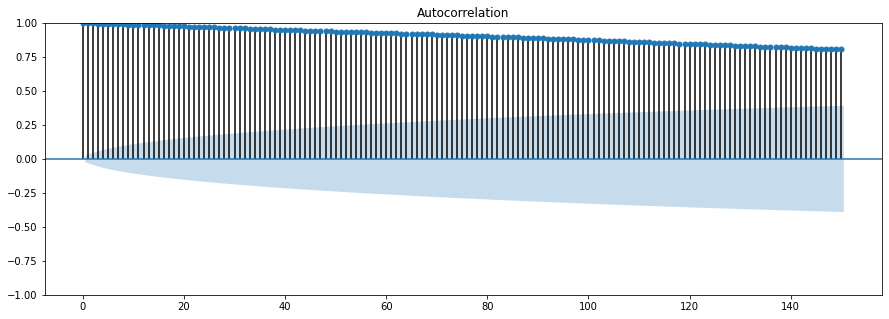

In [ ]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(y_train, ax=ax, lags=150)
plt.show()

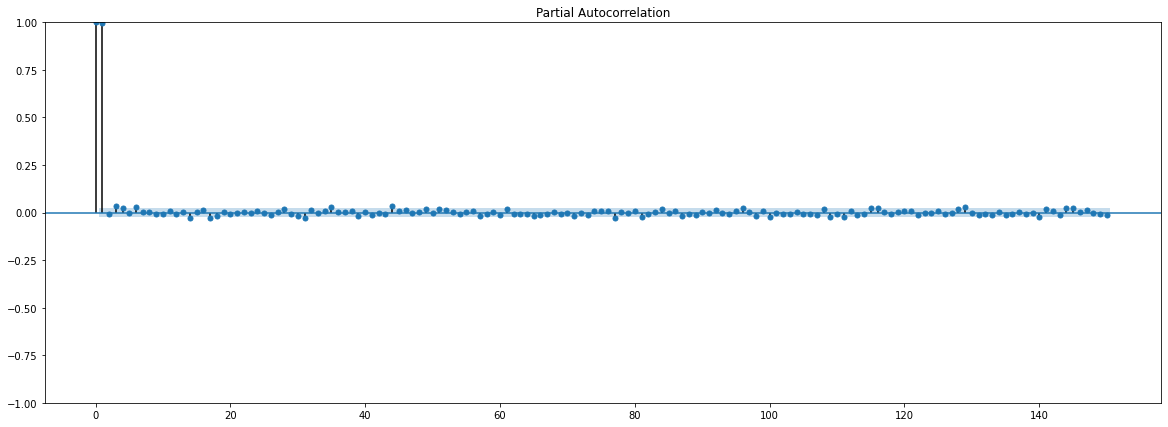

In [ ]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 7))
plot_pacf(y_train, ax=ax, lags=150, method='ywm')
plt.show()

In [ ]:
#Seleccionamos la variables exogenas, se incluyen las que se generaron por one-hot encoding.
exog_variables = [column for column in X_train.columns if column.startswith(tuple(categorical))]
exog_variables.extend(variables)
print(exog_variables)

['DIAMES', 'DIA_Friday', 'DIA_Monday', 'DIA_Thursday', 'DIA_Tuesday', 'DIA_Wednesday', 'MES_1', 'MES_2', 'MES_3', 'MES_4', 'MES_5', 'MES_6', 'MES_7', 'MES_8', 'MES_9', 'MES_10', 'MES_11', 'MES_12', 'Open', 'High', 'Low', 'Adj Close', 'Volume', 'Close', 'Target', 'DIAMES', 'SEMANA', 'ANTERIOR', 'DIF1', 'DIF3', 'DIF7', 'SUM3', 'SUM7', 'MEDIA3', 'MEDIA7', 'MEDIAN3', 'MEDIAN7', 'STD3', 'STD7']


### **XGBRegressor**

In [ ]:
X_train

,Open,High,Low,Close,Adj Close,Volume,Target,ANTERIOR,DIF1,DIF3,...,MES_3,MES_4,MES_5,MES_6,MES_7,MES_8,MES_9,MES_10,MES_11,MES_12
Date,,,,,,,,,,,,,,,,,,,,,
1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0,3654.500000,-24.199951,-25.700074,...,0,0,0,0,0,0,0,0,0,0
1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1,3654.500000,-24.199951,-25.700074,...,0,0,0,0,0,0,0,0,0,0
1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1,3630.300049,-9.100098,-25.700074,...,0,0,0,0,0,0,0,0,0,0
1994-01-06,3623.199951,3634.799926,3591.049926,3628.799926,3628.796264,0.0,0,3621.199951,7.599975,-25.700074,...,0,0,0,0,0,0,0,0,0,0
1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1,3628.799926,7.599976,6.099853,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-21,10192.599609,10322.599609,10144.400391,10304.599609,10304.599609,152663400.0,0,10207.700195,96.899414,60.500000,...,0,0,0,0,0,0,0,0,0,1
2017-12-22,10145.599609,10235.799805,10138.299805,10182.000000,10182.000000,138510600.0,0,10304.599609,-122.599609,-52.299805,...,0,0,0,0,0,0,0,0,0,1
2017-12-27,10167.200195,10213.200195,10138.799805,10165.200195,10165.200195,96218000.0,0,10182.000000,-16.799805,-42.500000,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Creamos el forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 20
                )
forecaster.fit(exog=pd.concat([X_train.drop(['Target'], axis=1)]), y=pd.concat([y_train]))
forecaster

/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:359: UserWarning: `exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`exog` has DatetimeIndex index but no frequency. '


[21:13:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


ForecasterAutoreg 
Regressor: XGBRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Window size: 20 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'ANTERIOR', 'DIF1', 'DIF3', 'DIF7', 'SUM3', 'SUM7', 'MEDIA3', 'MEDIA7', 'MEDIAN3', 'MEDIAN7', 'STD3', 'STD7', 'DIAMES', 'SEMANA', 'DIA_Friday', 'DIA_Monday', 'DIA_Thursday', 'DIA_Tuesday', 'DIA_Wednesday', 'MES_1', 'MES_2', 'MES_3', 'MES_4', 'MES_5', 'MES_6', 'MES_7', 'MES_8', 'MES_9', 'MES_10', 'MES_11', 'MES_12'] 
Training range: [0, 6194] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None

In [ ]:
# Extract feature importance
# ==============================================================================
importance = forecaster.get_feature_importance()
importance

,feature,importance
0,lag_1,0.369194
1,lag_2,0.029028
2,lag_3,0.016342
3,lag_4,0.000998
4,lag_5,0.135825
5,lag_6,0.000295
6,lag_7,0.000323
7,lag_8,0.003039
8,lag_9,0.000231
9,lag_10,0.004368


In [ ]:
steps=y_test.shape[0]

In [ ]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps, exog=X_test.drop(['Target'], axis=1))

/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:359: UserWarning: `exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`exog` has DatetimeIndex index but no frequency. '


In [ ]:
predicciones

6195    10319.039062
6196    10322.708008
6197    10324.171875
6198    10330.154297
6199    10330.154297
            ...     
6445    10177.288086
6446    10178.305664
6447    10179.960938
6448    10182.606445
6449    10182.009766
Name: pred, Length: 255, dtype: float64

In [ ]:
y_test

Date
2018-01-02    10411.400391
2018-01-03    10398.400391
2018-01-04    10426.500000
2018-01-05    10428.299805
2018-01-08    10435.200195
                  ...     
2018-12-21     8493.700195
2018-12-24     8539.900391
2018-12-27     8550.000000
2018-12-28     8523.299805
2018-12-31     8737.799805
Name: Close3, Length: 255, dtype: float64

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = predicciones
            )

error_r2 = r2_score(
                y_true = y_test,
                y_pred = predicciones
            )

error_rse = mean_squared_error(
                y_true = y_test,
                y_pred = predicciones,
                squared=False
            )

print(f"Error de test (mse): {error_mse}")
print(f"Error de test (rse): {error_rse}")
print(f"Error de test (r2): {error_r2}")

Error de test (mse): 626953.304217323
Error de test (rse): 791.803829377784
Error de test (r2): -1.6491540045640072


In [ ]:
#Verificamos las predicciones futuras con la correspondiente tercera
def get_target(predicciones, y_test):
  y_target = []
  for i in range(0, len(predicciones.values)):
    close = y_test.values[i]
    close3 = predicciones.values[i]
    if(close3 > close):
      y_target.append(1)
    else:
      y_target.append(0)
  return y_target

In [ ]:
y_target = get_target(predicciones, y_test)
print(metrics.classification_report(X_test['Target'][0:255], y_target))

              precision    recall  f1-score   support

           0       0.30      0.06      0.09       127
           1       0.48      0.88      0.62       128

    accuracy                           0.47       255
   macro avg       0.39      0.47      0.36       255
weighted avg       0.39      0.47      0.36       255



### **Random Forest**

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
from sklearn.ensemble import RandomForestRegressor
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 10
             )

forecaster.fit(exog=pd.concat([X_train.drop(['Target'], axis=1)]), y=pd.concat([y_train]))
forecaster

/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:359: UserWarning: `exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`exog` has DatetimeIndex index but no frequency. '
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window size: 10 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'ANTERIOR', 'DIF1', 'DIF3', 'DIF7', 'SUM3', 'SUM7', 'MEDIA3', 'MEDIA7', 'MEDIAN3', 'MEDIAN7', 'STD3', 'STD7', 'DIAMES', 'SEMANA', 'DIA_Friday', 'DIA_Monday', 'DIA_Thursday', 'DIA_Tuesday', 'DIA_Wednesday', 'MES_1', 'MES_2', 'MES_3', 'MES_4', 'MES_5', 'MES_6', 'MES_7', 'MES_8', 'MES_9', 'MES_10', 'MES_11', 'MES_12'] 
Training range: [0, 6194] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n

In [ ]:
# Extract feature importance
# ==============================================================================
importance = forecaster.get_feature_importance()
importance

,feature,importance
0,lag_1,0.923712
1,lag_2,0.001452
2,lag_3,0.000026
3,lag_4,0.000751
4,lag_5,0.038077
5,lag_6,0.018558
6,lag_7,0.002298
7,lag_8,0.001567
8,lag_9,0.000073
9,lag_10,0.000816


In [ ]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps, exog=X_test.drop(['Target'], axis=1))

/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:359: UserWarning: `exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`exog` has DatetimeIndex index but no frequency. '


In [ ]:
predicciones

6195    10259.993047
6196    10215.548008
6197    10192.446016
6198    10207.358037
6199    10182.308096
            ...     
6445    10130.229053
6446    10161.442656
6447    10188.212031
6448    10236.962012
6449    10212.345986
Name: pred, Length: 255, dtype: float64

In [ ]:
y_test

Date
2018-01-02    10411.400391
2018-01-03    10398.400391
2018-01-04    10426.500000
2018-01-05    10428.299805
2018-01-08    10435.200195
                  ...     
2018-12-21     8493.700195
2018-12-24     8539.900391
2018-12-27     8550.000000
2018-12-28     8523.299805
2018-12-31     8737.799805
Name: Close3, Length: 255, dtype: float64

In [ ]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = predicciones
            )

error_r2 = r2_score(
                y_true = y_test,
                y_pred = predicciones
            )

error_rse = mean_squared_error(
                y_true = y_test,
                y_pred = predicciones,
                squared=False
            )

print(f"Error de test (mse): {error_mse}")
print(f"Error de test (rse): {error_rse}")
print(f"Error de test (r2): {error_r2}")

Error de test (mse): 496029.9198807066
Error de test (rse): 704.2939158339411
Error de test (r2): -1.0959450086573597


In [ ]:
y_target = get_target(predicciones, y_test)
print(metrics.classification_report(X_test['Target'][0:255], y_target))

              precision    recall  f1-score   support

           0       0.43      0.12      0.19       127
           1       0.49      0.84      0.62       128

    accuracy                           0.48       255
   macro avg       0.46      0.48      0.40       255
weighted avg       0.46      0.48      0.40       255



### **Probando Mejor modelo con Validation set**

In [ ]:
X_val

,Open,High,Low,Close,Adj Close,Volume,Target,ANTERIOR,DIF1,DIF3,...,MES_3,MES_4,MES_5,MES_6,MES_7,MES_8,MES_9,MES_10,MES_11,MES_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,8448.299805,8582.400391,8354.799805,8550.000000,8550.000000,130757800.0,1,8539.900391,10.099609,186.099609,...,0,0,0,0,0,0,0,0,0,0
2019-01-03,8497.500000,8590.900391,8488.099609,8523.299805,8523.299805,135067300.0,1,8550.000000,-26.700195,29.599610,...,0,0,0,0,0,0,0,0,0,0
2019-01-04,8593.799805,8774.299805,8588.099609,8737.799805,8737.799805,169088900.0,1,8523.299805,214.500000,197.899414,...,0,0,0,0,0,0,0,0,0,0
2019-01-07,8781.200195,8783.500000,8710.400391,8776.299805,8776.299805,128758600.0,1,8737.799805,38.500000,226.299805,...,0,0,0,0,0,0,0,0,0,0
2019-01-08,8783.099609,8895.900391,8773.400391,8847.299805,8847.299805,160821000.0,1,8776.299805,71.000000,324.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-24,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0,9114.000000,60.599609,-64.500000,...,0,0,1,0,0,0,0,0,0,0
2019-05-27,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0,9174.599609,41.800782,-15.799804,...,0,0,1,0,0,0,0,0,0,0
2019-05-28,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0,9216.400391,-24.600586,77.799805,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
y_val

Date
2019-01-02    8776.299805
2019-01-03    8847.299805
2019-01-04    8823.599609
2019-01-07    8856.799805
2019-01-08    8877.099609
                 ...     
2019-05-24    9080.500000
2019-05-27    9157.799805
2019-05-28    9157.799805
2019-05-29    9157.799805
2019-05-30    9157.799805
Name: Close3, Length: 104, dtype: float64

In [ ]:
predicciones_val = forecaster.predict(steps=X_val.shape[0], exog=X_val.drop(['Target'], axis=1))

/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:359: UserWarning: `exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`exog` has DatetimeIndex index but no frequency. '


In [ ]:
predicciones_val

6195    10245.574990
6196    10144.170996
6197    10131.050039
6198    10116.981006
6199    10079.364033
            ...     
6294    10087.487705
6295    10092.253726
6296    10098.719712
6297    10114.542695
6298    10087.125693
Name: pred, Length: 104, dtype: float64

In [ ]:
y_val

Date
2019-01-02    8776.299805
2019-01-03    8847.299805
2019-01-04    8823.599609
2019-01-07    8856.799805
2019-01-08    8877.099609
                 ...     
2019-05-24    9080.500000
2019-05-27    9157.799805
2019-05-28    9157.799805
2019-05-29    9157.799805
2019-05-30    9157.799805
Name: Close3, Length: 104, dtype: float64

In [ ]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_val,
                y_pred = predicciones_val
            )

error_r2 = r2_score(
                y_true = y_val,
                y_pred = predicciones_val
            )

error_rse = mean_squared_error(
                y_true = y_val,
                y_pred = predicciones_val,
                squared=False
            )

print(f"Error de test (mse): {error_mse}")
print(f"Error de test (rse): {error_rse}")
print(f"Error de test (r2): {error_r2}")

Error de test (mse): 791973.3606845475
Error de test (rse): 889.9288514732779
Error de test (r2): -20.21786601290539


In [ ]:
y_target = get_target(predicciones_val, y_val)
print(metrics.classification_report(X_val['Target'][0:104], y_target))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.57      1.00      0.72        59

    accuracy                           0.57       104
   macro avg       0.28      0.50      0.36       104
weighted avg       0.32      0.57      0.41       104



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


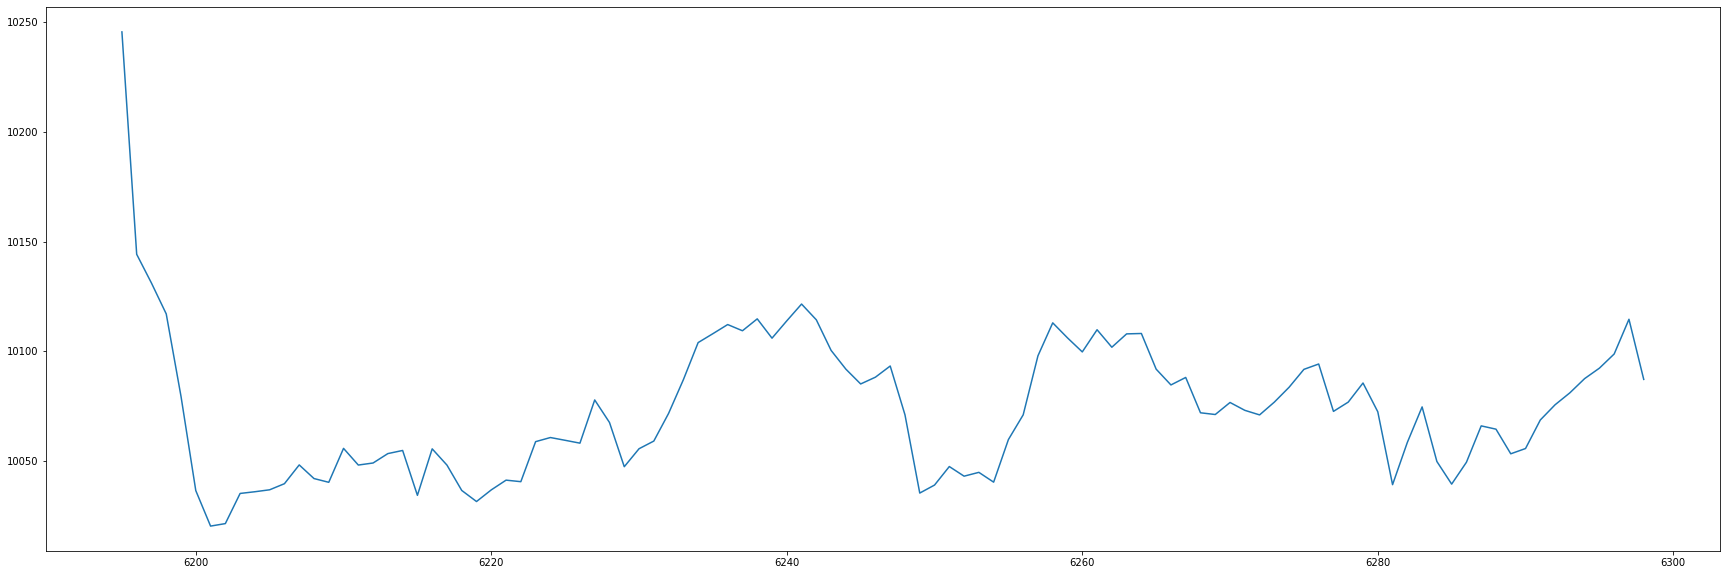

In [ ]:
predicciones_val.plot(figsize=(30,10))

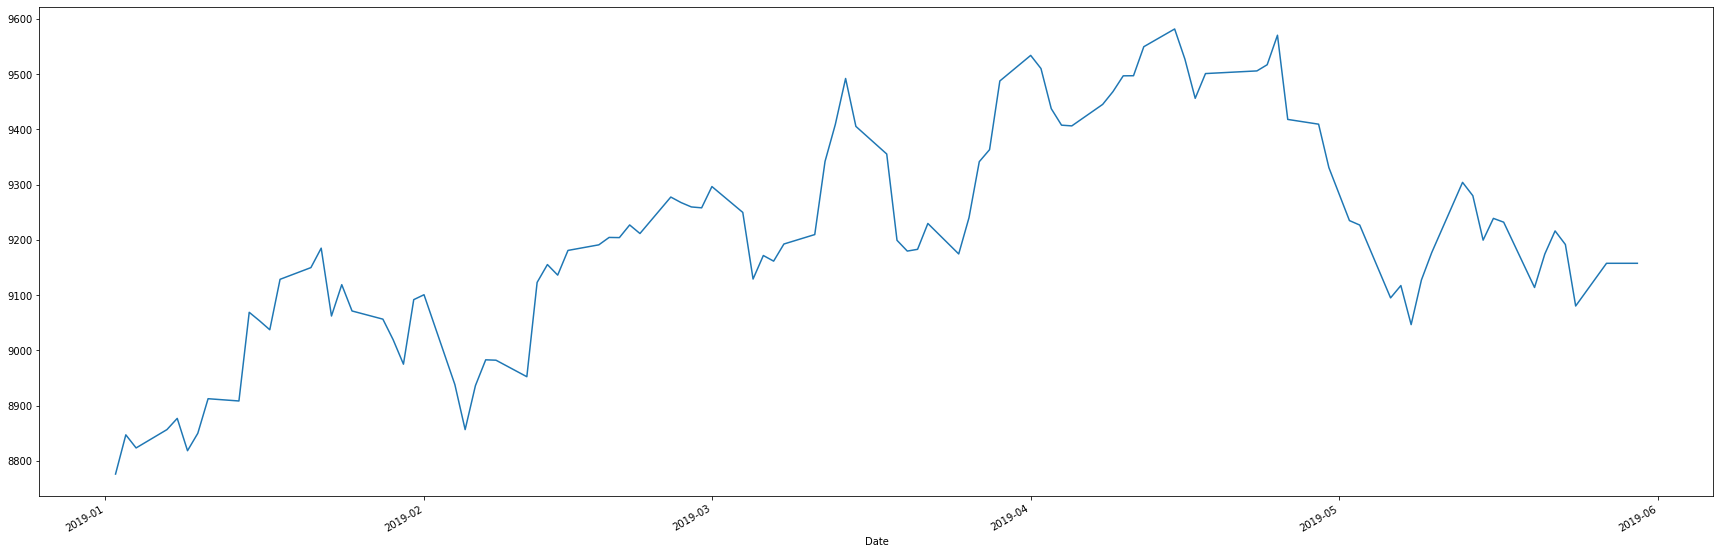

In [ ]:
y_val.plot(figsize=(30,10))

### **Prediciendo fechas en particual**

In [ ]:
mayo2019 = newDF.loc['2019-05-01': ]
mayo2019

,Open,High,Low,Close,Adj Close,Volume,Target,Close3,ANTERIOR,DIF1,...,MES_3,MES_4,MES_5,MES_6,MES_7,MES_8,MES_9,MES_10,MES_11,MES_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-05-02,9545.500000,9559.700195,9412.200195,9418.200195,9418.200195,205611000.0,0,9235.099609,9570.599609,-152.399414,...,0,0,1,0,0,0,0,0,0,0
2019-05-03,9427.900391,9450.700195,9388.700195,9409.599609,9409.599609,126736800.0,0,9227.000000,9418.200195,-8.600586,...,0,0,1,0,0,0,0,0,0,0
2019-05-06,9259.000000,9347.200195,9236.299805,9331.000000,9331.000000,121602300.0,0,9095.200195,9409.599609,-78.599609,...,0,0,1,0,0,0,0,0,0,0
2019-05-07,9332.900391,9404.599609,9221.000000,9235.099609,9235.099609,199265700.0,0,9117.500000,9331.000000,-95.900391,...,0,0,1,0,0,0,0,0,0,0
2019-05-08,9233.900391,9261.200195,9158.299805,9227.000000,9227.000000,185752600.0,0,9046.799805,9235.099609,-8.099609,...,0,0,1,0,0,0,0,0,0,0
2019-05-09,9162.099609,9184.799805,9079.799805,9095.200195,9095.200195,166997800.0,1,9127.599609,9227.000000,-131.799805,...,0,0,1,0,0,0,0,0,0,0
2019-05-10,9149.400391,9179.400391,9099.099609,9117.500000,9117.500000,147760300.0,1,9177.099609,9095.200195,22.299805,...,0,0,1,0,0,0,0,0,0,0
2019-05-13,9127.599609,9127.599609,9025.700195,9046.799805,9046.799805,147442300.0,1,9304.299805,9117.500000,-70.700195,...,0,0,1,0,0,0,0,0,0,0
2019-05-14,9078.200195,9127.599609,9053.599609,9127.599609,9127.599609,139675700.0,1,9280.099609,9046.799805,80.799804,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
#El numero de lags que mejor funciona es 10
last_window = mayo2019['Close'][0:10]
last_window

Date
2019-05-02    9418.200195
2019-05-03    9409.599609
2019-05-06    9331.000000
2019-05-07    9235.099609
2019-05-08    9227.000000
2019-05-09    9095.200195
2019-05-10    9117.500000
2019-05-13    9046.799805
2019-05-14    9127.599609
2019-05-15    9177.099609
Name: Close, dtype: float64

In [ ]:
toPredict = mayo2019[10:11].drop(['Target', 'Close3'], axis=1)
toPredict

,Open,High,Low,Close,Adj Close,Volume,ANTERIOR,DIF1,DIF3,DIF7,...,MES_3,MES_4,MES_5,MES_6,MES_7,MES_8,MES_9,MES_10,MES_11,MES_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-05-16,9161.400391,9304.299805,9136.700195,9304.299805,9304.299805,157566000.0,9177.099609,127.200196,257.5,69.200196,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
def predecir_targets(last_window, exog, step=1):
  predicciones_val = forecaster.predict(last_window=last_window, steps=step, exog=exog)
  #El precio del cierre predicho es mayor al precio del cierre actual
  if(predicciones_val.values[0] > exog.Close.values[0]):
      return 1
  else:
      return 0

In [ ]:
#Se predice el valor de los 3 siguientes valores de Close
predicciones_val = predecir_targets(last_window, toPredict)
print(predicciones_val)

0


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:359: UserWarning: `exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`exog` has DatetimeIndex index but no frequency. '
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '


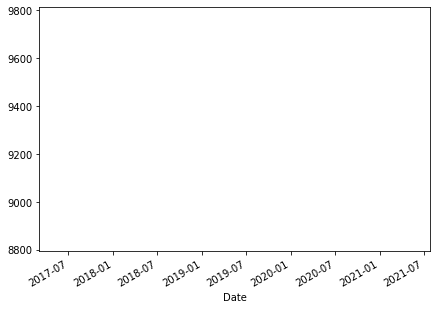

In [ ]:
toPredict['Close'][0:1].plot(figsize=(7,5))

In [ ]:
predicciones_val.plot(figsize=(7,5))

AttributeError: ignored

# **Dataset de testing**

In [ ]:
testDF = pd.read_csv('test_x.csv', sep=',', encoding='utf-8')
testDF.head()

,test_index,Date,Open,High,Low,Close,Adj Close,Volume
0,6557,2019-06-05,9136.799805,9173.400391,9095.000000,9150.500000,9150.500000,158753000.0
1,6558,2019-06-06,9169.200195,9246.200195,9136.700195,9169.200195,9169.200195,212720900.0
2,6559,2019-06-07,9186.700195,9261.400391,9185.700195,9236.099609,9236.099609,150664700.0
3,6560,2019-06-10,9284.200195,9302.200195,9248.099609,9294.099609,9294.099609,102323700.0
4,6561,2019-06-11,9288.599609,9332.500000,9273.400391,9282.099609,9282.099609,144701200.0


In [ ]:
testDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726 entries, 0 to 725
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   test_index  726 non-null    int64  
 1   Date        726 non-null    object 
 2   Open        726 non-null    float64
 3   High        726 non-null    float64
 4   Low         726 non-null    float64
 5   Close       726 non-null    float64
 6   Adj Close   726 non-null    float64
 7   Volume      726 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 45.5+ KB


In [ ]:
#Vemos si tenemos missing values
testDF.isna().sum()

test_index    0
Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
dtype: int64

In [ ]:
#Observamos un summary de los datos
testDF.describe()

,test_index,Open,High,Low,Close,Adj Close,Volume
count,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,7.260000e+02
mean,6919.500000,8399.936418,8458.035202,8332.158471,8396.085609,8396.085609,2.086387e+08
std,209.722436,899.325142,886.671165,916.904022,903.320144,903.320144,1.015796e+08
min,6557.000000,6223.700195,6362.500000,5814.500000,6107.200195,6107.200195,3.543620e+07
25%,6738.250000,7848.675049,7963.874878,7762.924805,7857.675171,7857.675171,1.472686e+08
50%,6919.500000,8673.950195,8725.250000,8609.750000,8672.399902,8672.399902,1.827458e+08
75%,7100.750000,9077.599609,9124.224854,9001.125244,9077.375244,9077.375244,2.340954e+08
max,7282.000000,10048.700195,10100.200195,10020.700195,10083.599609,10083.599609,9.752120e+08


In [ ]:
testDF

,test_index,Date,Open,High,Low,Close,Adj Close,Volume
0,6557,2019-06-05,9136.799805,9173.400391,9095.000000,9150.500000,9150.500000,158753000.0
1,6558,2019-06-06,9169.200195,9246.200195,9136.700195,9169.200195,9169.200195,212720900.0
2,6559,2019-06-07,9186.700195,9261.400391,9185.700195,9236.099609,9236.099609,150664700.0
3,6560,2019-06-10,9284.200195,9302.200195,9248.099609,9294.099609,9294.099609,102323700.0
4,6561,2019-06-11,9288.599609,9332.500000,9273.400391,9282.099609,9282.099609,144701200.0
...,...,...,...,...,...,...,...,...
721,7278,2022-03-25,8314.099609,8363.200195,8286.500000,8330.599609,8330.599609,156189000.0
722,7279,2022-03-28,8354.400391,8485.700195,8354.400391,8365.599609,8365.599609,167961800.0
723,7280,2022-03-29,8451.000000,8621.000000,8419.700195,8614.599609,8614.599609,257812200.0
724,7281,2022-03-30,8583.299805,8597.400391,8508.900391,8550.599609,8550.599609,185389000.0


In [ ]:
testDF['Date'] = pd.to_datetime(testDF['Date'])

In [ ]:
testDF['ANTERIOR'] = testDF['Close'].shift().ffill().bfill()
testDF['DIF1'] = testDF['Close'].diff().ffill().bfill()
testDF['DIF3'] = testDF['Close'].diff(periods=3).ffill().bfill()
testDF['DIF7'] = testDF['Close'].diff(periods=7).ffill().bfill()
testDF['SUM3'] = testDF['Close'].rolling(3).sum().ffill().bfill()
testDF['SUM7'] = testDF['Close'].rolling(7).sum().ffill().bfill()
testDF['MEDIA3'] = testDF['Close'].rolling(3).mean().ffill().bfill()
testDF['MEDIA7'] = testDF['Close'].rolling(7).mean().ffill().bfill()
testDF['MEDIAN3'] = testDF['Close'].rolling(3).median().ffill().bfill()
testDF['MEDIAN7'] = testDF['Close'].rolling(7).median().ffill().bfill()
testDF['STD3'] = testDF['Close'].rolling(3).std().ffill().bfill()
testDF['STD7'] = testDF['Close'].rolling(7).std().ffill().bfill()
testDF['DIA'] = testDF['Date'].dt.day_name()
testDF['DIAMES'] = testDF['Date'].dt.day
testDF['SEMANA'] = testDF['Date'].dt.isocalendar().week
testDF['MES'] = testDF['Date'].dt.month

In [132]:
# Transformamos el df agregando las variables numericas y variables categoricas
# ==============================================================================
target = 'Close'
categorical = ['DIA', 'MES']
variables = ['test_index', 'Open', 'High', 'Low', 'Adj Close', 'Volume', 'Close', 'Target', 'DIAMES', 'SEMANA', 'ANTERIOR', 'DIF1', 'DIF3', 'DIF7', 'SUM3', 'SUM7', 'MEDIA3', 'MEDIA7', 'MEDIAN3', 'MEDIAN7', 'STD3', 'STD7']

newTestDF = transform_variables(testDF, target, variables, categorical)

## **Predicción**

In [134]:
newTestDF

,test_index,Open,High,Low,Close,Adj Close,Volume,ANTERIOR,DIF1,DIF3,...,MES_3,MES_4,MES_5,MES_6,MES_7,MES_8,MES_9,MES_10,MES_11,MES_12
0,6557,9136.799805,9173.400391,9095.000000,9150.500000,9150.500000,158753000.0,9150.500000,18.700195,143.599609,...,0,0,0,1,0,0,0,0,0,0
1,6558,9169.200195,9246.200195,9136.700195,9169.200195,9169.200195,212720900.0,9150.500000,18.700195,143.599609,...,0,0,0,1,0,0,0,0,0,0
2,6559,9186.700195,9261.400391,9185.700195,9236.099609,9236.099609,150664700.0,9169.200195,66.899414,143.599609,...,0,0,0,1,0,0,0,0,0,0
3,6560,9284.200195,9302.200195,9248.099609,9294.099609,9294.099609,102323700.0,9236.099609,58.000000,143.599609,...,0,0,0,1,0,0,0,0,0,0
4,6561,9288.599609,9332.500000,9273.400391,9282.099609,9282.099609,144701200.0,9294.099609,-12.000000,112.899414,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,7278,8314.099609,8363.200195,8286.500000,8330.599609,8330.599609,156189000.0,8305.099609,25.500000,-156.600586,...,1,0,0,0,0,0,0,0,0,0
722,7279,8354.400391,8485.700195,8354.400391,8365.599609,8365.599609,167961800.0,8330.599609,35.000000,37.199218,...,1,0,0,0,0,0,0,0,0,0
723,7280,8451.000000,8621.000000,8419.700195,8614.599609,8614.599609,257812200.0,8365.599609,249.000000,309.500000,...,1,0,0,0,0,0,0,0,0,0
724,7281,8583.299805,8597.400391,8508.900391,8550.599609,8550.599609,185389000.0,8614.599609,-64.000000,220.000000,...,1,0,0,0,0,0,0,0,0,0


In [123]:
last_window = newDF['Close'][-10:]

In [124]:
last_window

Date
2019-05-17    9280.099609
2019-05-20    9199.700195
2019-05-21    9239.099609
2019-05-22    9232.200195
2019-05-23    9114.000000
2019-05-24    9174.599609
2019-05-27    9216.400391
2019-05-28    9191.799805
2019-05-29    9080.500000
2019-05-30    9157.799805
Name: Close, dtype: float64

In [146]:
targets = []
for index, row in newTestDF.iterrows():
    print(index)
    if index < 10:
      last_window =  newDF['Close'][-10:]
    rowdf = pd.DataFrame(newTestDF.loc[index:index])
    target = predecir_targets(last_window, rowdf)
    targets.append((rowdf['test_index'].values[0], target))
    last_window = pd.concat([last_window, rowdf['Close']])
targets

0
1
2
3
4
5
6


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has Dateti

7
8
9
10
11
12
13


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has Dateti

14
15
16
17
18
19


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

20
21
22
23
24
25
26


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

27
28
29
30
31
32
33
34


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

35
36
37
38
39
40
41


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

42
43
44
45
46
47
48
49


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

50
51
52
53
54
55
56
57
58


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

59
60
61
62
63
64
65


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

66
67
68
69
70
71
72
73


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

74
75
76
77
78
79
80


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

81
82
83
84
85
86
87
88
89


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

90
91
92
93
94
95
96
97


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

98
99
100
101
102
103
104
105


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

106
107
108
109
110
111
112
113


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

114
115
116
117
118
119
120
121

/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l


122
123
124
125
126
127
128


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

129
130
131
132
133
134
135
136


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

137
138
139
140
141
142
143
144


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

145
146
147
148
149


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

150
151
152
153
154


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

155
156
157
158
159
160

/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l


161
162
163
164
165


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

166
167
168
169
170
171
172
173
174
175
176
177
178
179


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

180
181
182
183
184
185
186
187


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

188
189
190
191
192
193
194
195


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

196
197
198
199
200
201
202
203


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

204
205
206
207
208
209


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

210
211
212
213


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

214
215
216


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex

217
218
219
220
221


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

222
223
224
225
226
227
228
229
230
231
232
233
234


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

235
236
237
238
239
240
241
242
243
244
245
246


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

247
248
249
250
251
252
253
254
255
256
257
258


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

259
260
261
262
263
264
265
266
267
268
269


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

270
271
272
273
274
275
276
277
278
279
280
281
282
283


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

284
285
286
287
288
289
290
291
292
293
294
295


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

296
297
298
299
300
301
302
303
304
305
306
307
308
309


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

334
335
336
337
338
339
340
341
342
343


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

344
345
346
347
348
349
350
351
352
353
354
355
356
357


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

358
359
360
361
362
363
364
365
366
367
368
369
370


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

371
372
373
374
375
376
377
378
379
380
381
382


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

383
384
385
386
387
388
389
390
391
392


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

393
394
395
396
397
398
399
400
401
402
403
404
405


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

406
407
408
409
410
411
412
413
414
415
416
417


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

418
419
420
421
422
423
424
425
426
427
428
429
430


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

431
432
433
434
435
436
437
438
439
440
441
442
443


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

444
445
446
447
448
449
450
451
452
453
454


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

455
456
457
458
459
460
461
462


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

463
464
465
466
467
468
469
470


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

471
472
473
474
475
476
477
478


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

479
480
481
482
483
484
485


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

486
487
488
489
490
491
492


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

493
494
495
496
497
498
499
500


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

501
502
503
504
505
506
507


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

508
509
510
511
512
513
514
515


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

516
517
518
519
520
521
522
523


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

524
525
526
527
528
529
530


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

531
532
533
534
535
536
537
538


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

539
540
541
542
543
544
545
546


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex

547
548
549
550
551
552
553
554


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

555
556
557
558
559
560
561


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

562
563
564
565
566
567
568
569


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

570
571
572
573
574
575
576
577


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

578
579
580
581
582
583
584


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

585
586
587
588
589
590
591


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

592
593
594
595
596
597
598


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

599
600
601
602
603
604
605


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

606
607
608
609
610
611
612
613


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

614
615
616
617
618
619
620
621


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex

622
623
624
625
626
627
628
629


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

630
631
632
633
634
635
636
637


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

638
639
640
641
642
643
644


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

645
646
647
648
649
650
651
652


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

653
654
655
656
657
658
659
660


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

661
662
663
664
665
666
667
668


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

669
670
671
672
673
674
675
676


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

677
678
679
680
681
682
683
684
685
686
687
688
689
690
691


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

692
693
694
695
696
697
698
699


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

700
701
702
703
704
705
706


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

707
708
709
710
711
712
713
714
715
716
717
718
719


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

720
721
722
723
724
725


/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:370: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/usr/local/lib/python3.7/dist-packages/skforecast/utils/utils.py:312: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`l

[(6557, 1),
 (6558, 1),
 (6559, 0),
 (6560, 0),
 (6561, 0),
 (6562, 0),
 (6563, 0),
 (6564, 1),
 (6565, 1),
 (6566, 0),
 (6567, 1),
 (6568, 1),
 (6569, 1),
 (6570, 1),
 (6571, 1),
 (6572, 1),
 (6573, 1),
 (6574, 0),
 (6575, 0),
 (6576, 0),
 (6577, 0),
 (6578, 1),
 (6579, 1),
 (6580, 1),
 (6581, 1),
 (6582, 1),
 (6583, 0),
 (6584, 1),
 (6585, 1),
 (6586, 0),
 (6587, 1),
 (6588, 1),
 (6589, 1),
 (6590, 1),
 (6591, 0),
 (6592, 0),
 (6593, 1),
 (6594, 1),
 (6595, 1),
 (6596, 1),
 (6597, 1),
 (6598, 0),
 (6599, 1),
 (6600, 1),
 (6601, 1),
 (6602, 0),
 (6603, 0),
 (6604, 1),
 (6605, 1),
 (6606, 0),
 (6607, 1),
 (6608, 0),
 (6609, 0),
 (6610, 0),
 (6611, 1),
 (6612, 0),
 (6613, 0),
 (6614, 1),
 (6615, 0),
 (6616, 0),
 (6617, 0),
 (6618, 0),
 (6619, 0),
 (6620, 0),
 (6621, 0),
 (6622, 0),
 (6623, 0),
 (6624, 1),
 (6625, 0),
 (6626, 0),
 (6627, 1),
 (6628, 0),
 (6629, 0),
 (6630, 1),
 (6631, 1),
 (6632, 0),
 (6633, 0),
 (6634, 1),
 (6635, 1),
 (6636, 0),
 (6637, 0),
 (6638, 0),
 (6639, 0),
 (66

In [149]:
result = pd.DataFrame(targets, columns=['test_index', 'target'])
result

,test_index,target
0,6557,1
1,6558,1
2,6559,0
3,6560,0
4,6561,0
...,...,...
721,7278,0
722,7279,0
723,7280,0
724,7281,1


In [150]:
result.to_csv('predictions.csv', encoding="utf-8", index=False)

In [151]:
result.to_json('predictions.json')